In [1]:
pip install pandas numpy nltk seaborn matplotlib scikit-learn 


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\huawei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\huawei\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\huawei\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Load dataset and split in 20 80

In [4]:
# Load dataset 
df = pd.read_csv("D:/Scarlett/All/Mcgill/Courses/Winter/Text analysis/Assignment2/Train_rev1.csv")

# Randomly sample 2500 rows
df_sample = df.sample(n=2500, random_state=42)

# Define high vs. low salary threshold (75th percentile)
salary_threshold = df_sample['SalaryNormalized'].quantile(0.75)
df_sample['HighSalary'] = (df_sample['SalaryNormalized'] > salary_threshold).astype(int)

# Split dataset
train_data, test_data = train_test_split(df_sample, test_size=0.2, random_state=42)


Preprocessing and convert to numerical features

In [5]:
# Preprocessing
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(str(text).lower())
    words = [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word not in stop_words]
    return " ".join(words)

df_sample['ProcessedDescription'] = df_sample['FullDescription'].apply(preprocess_text)

# Convert salary into binary classes (high salary vs. low salary)
salary_threshold = df_sample['SalaryNormalized'].quantile(0.75)
df_sample['SalaryClass'] = (df_sample['SalaryNormalized'] >= salary_threshold).astype(int)

# Split into train & test sets
X = df_sample['ProcessedDescription']
y = df_sample['SalaryClass']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text to numerical features (TF-IDF)
tfidf = TfidfVectorizer(max_features=2000, min_df=2)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

Train Naive Bayes

In [7]:
# Train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)
nb_accuracy = accuracy_score(y_test, y_pred_nb)
print(f'Naïve Bayes Accuracy: {nb_accuracy:.4f}')

Naïve Bayes Accuracy: 0.7800


Train KNN

In [8]:
# Train KNN model with optimal k
def tune_knn(k_values):
    best_k, best_acc = 0, 0
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_tfidf, y_train)
        acc = accuracy_score(y_test, knn.predict(X_test_tfidf))
        if acc > best_acc:
            best_k, best_acc = k, acc
    return best_k, best_acc
best_k, knn_accuracy = tune_knn(range(3, 21, 2))
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train_tfidf, y_train)
y_pred_knn = knn_model.predict(X_test_tfidf)
print(f'KNN (k={best_k}) Accuracy: {knn_accuracy:.4f}')

KNN (k=9) Accuracy: 0.7680


Tunning Naive Bayes

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
import numpy as np

# Define possible values for alpha
param_grid = {'alpha': np.linspace(0.01, 1, 10)}

# Initialize the Naïve Bayes classifier
nb = MultinomialNB()

# Use GridSearchCV to find the best alpha
best_accuracy_Naive = GridSearchCV(nb, param_grid, cv=5, scoring='accuracy')
best_accuracy_Naive.fit(X_train_tfidf, y_train)

# Get the best model and alpha
best_alpha = best_accuracy_Naive.best_params_['alpha']
best_nb = best_accuracy_Naive.best_estimator_
best_accuracy_NaiveBayes = best_accuracy_Naive.best_score_  # Corrected this line

# Print results
print(f"Best alpha: {best_alpha}")
print(f"Best accuracy: {best_accuracy_NaiveBayes:.4f}")


Best alpha: 0.12
Best accuracy: 0.7955


Tunning KNN

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': range(1, 50, 2),  # Try odd values for k
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # Manhattan vs. Euclidean distance
}

knn = KNeighborsClassifier()
best_accuracy_KN= GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
best_accuracy_KN.fit(X_train_tfidf, y_train)
best_accuracy_KNN= best_accuracy_KN.best_score_
print(f"Best k: {best_accuracy_KN.best_params_['n_neighbors']}")
print(f"Best weights: {best_accuracy_KN.best_params_['weights']}")
print(f"Best p: {best_accuracy_KN.best_params_['p']}")
print(f"Best accuracy: {best_accuracy_KNN:.4f}")


Best k: 13
Best weights: distance
Best p: 2
Best accuracy: 0.7845


Train Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_tfidf, y_train)
y_pred_log_reg = log_reg.predict(X_test_tfidf)

accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print("Logistic Regression Accuracy:", accuracy_log_reg)


Logistic Regression Accuracy: 0.788


Tunning Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize model
log_reg = LogisticRegression(max_iter=1000)

# Perform grid search
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_tfidf, y_train)

# Best parameter and accuracy
best_C = grid_search.best_params_['C']
best_accuracy_log_reg = grid_search.best_score_

print(f"Best C for Logistic Regression: {best_C}")
print(f"Best Accuracy: {best_accuracy_log_reg:.4f}")


Best C for Logistic Regression: 10
Best Accuracy: 0.8040


Train SVM

In [15]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0)  # Try different C values for tuning
svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy:", accuracy_svm)


SVM Accuracy: 0.796


Tunning SVM

In [16]:
from sklearn.svm import SVC

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100], 
    'kernel': ['linear', 'rbf']
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_tfidf, y_train)

best_C_svm = grid_search.best_params_['C']
best_kernel = grid_search.best_params_['kernel']
best_accuracy_svm = grid_search.best_score_

print(f"Best C for SVM: {best_C_svm}")
print(f"Best Kernel for SVM: {best_kernel}")
print(f"Best Accuracy: {best_accuracy_svm:.4f}")


Best C for SVM: 1
Best Kernel for SVM: linear
Best Accuracy: 0.8080


Train RF

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tfidf, y_train)
y_pred_rf = rf.predict(X_test_tfidf)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)


Random Forest Accuracy: 0.76


Tunning RF

In [18]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_tfidf, y_train)

best_n_estimators = grid_search.best_params_['n_estimators']
best_max_depth = grid_search.best_params_['max_depth']
best_accuracy_rf = grid_search.best_score_

print(f"Best n_estimators for Random Forest: {best_n_estimators}")
print(f"Best max_depth for Random Forest: {best_max_depth}")
print(f"Best Accuracy: {best_accuracy_rf:.4f}")


Best n_estimators for Random Forest: 200
Best max_depth for Random Forest: 30
Best Accuracy: 0.7720


Compare models

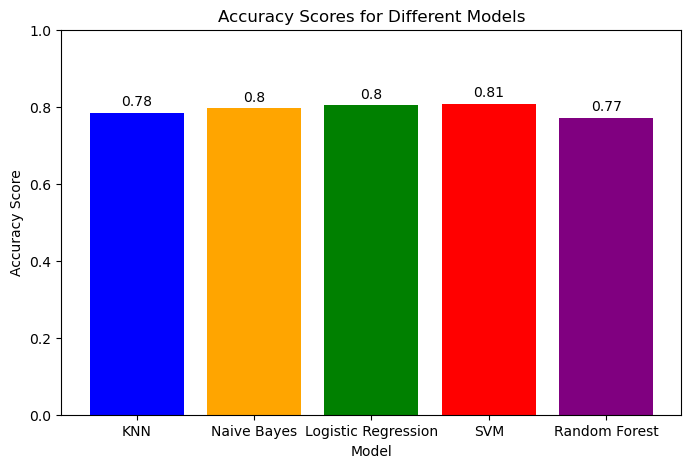

In [19]:
import matplotlib.pyplot as plt


# List of models and their corresponding accuracy scores
models = ['KNN', 'Naive Bayes', 'Logistic Regression', 'SVM', 'Random Forest']
accuracies = [best_accuracy_KNN, best_accuracy_NaiveBayes, best_accuracy_log_reg, best_accuracy_svm, best_accuracy_rf]

# Create a bar plot for the accuracy scores
plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=['blue', 'orange', 'green', 'red', 'purple'])

# Add the accuracy numbers on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# Labeling the axes and title
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores for Different Models')
plt.ylim(0, 1)  # Set the y-axis to range from 0 to 1, since accuracy is between 0 and 1
plt.show()


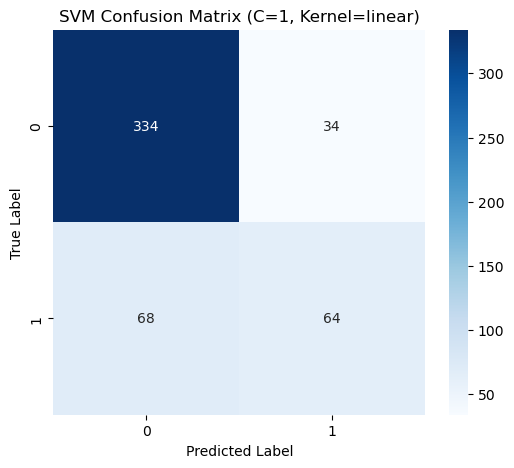

Top 10 words for high salary: ['senior' 'strategic' 'lead' 'social' 'director' 'global' 'partner'
 'leadership' 'project' 'head']
Top 10 words for low salary: ['well' 'travel' 'assistant' 'manufacturing' 'wcf' 'hour' 'charity'
 'database' 'applicant' 'customer']


In [20]:
# Confusion Matrix for SVM
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues')
plt.title(f'SVM Confusion Matrix (C={best_C_svm}, Kernel={best_kernel})')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Extract top words indicative of high & low salary using SVM coefficients
feature_names = np.array(tfidf.get_feature_names_out())
svm_coef = svm.coef_.toarray()  # Get the coefficients for the SVM model

def get_top_words_svm(class_idx, top_n=10):
    # For binary classification, svm.coef_ has shape (1, n_features), 
    # We want to access the coefficients corresponding to the high salary and low salary classes
    if class_idx == 1:  # High salary (class 1)
        sorted_idx = np.argsort(svm_coef[0])[-top_n:]  # Sort by highest coefficient (positive)
    else:  # Low salary (class 0)
        sorted_idx = np.argsort(svm_coef[0])[:top_n]  # Sort by lowest coefficient (negative)
    
    return feature_names[sorted_idx][::-1]  # Reverse to show most important first

# Extract top 10 words for high salary and low salary
top_high_salary_words = get_top_words_svm(1)  # Class 1 → High salary
top_low_salary_words = get_top_words_svm(0)   # Class 0 → Low salary

print("Top 10 words for high salary:", top_high_salary_words)
print("Top 10 words for low salary:", top_low_salary_words)
